In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("heart.csv")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


# Cleaning Null

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


*There are no columns containing null values*

# Removing outliers

In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


*Some columns may have outliers : `RestingBP`, `Cholesterol`, `MaxHR`, `Oldpeak`*

In [6]:
df = df[(df.RestingBP<(df.RestingBP.mean()+3*df.RestingBP.std())) & 
       (df.RestingBP>(df.RestingBP.mean()-3*df.RestingBP.std()))]

In [7]:
df = df[(df.Cholesterol<(df.Cholesterol.mean()+3*df.Cholesterol.std())) & 
       (df.Cholesterol>(df.Cholesterol.mean()-3*df.Cholesterol.std()))]

In [8]:
df = df[(df.MaxHR<(df.MaxHR.mean()+3*df.MaxHR.std())) & 
       (df.MaxHR>(df.MaxHR.mean()-3*df.MaxHR.std()))]

In [9]:
df = df[(df.Oldpeak<(df.Oldpeak.mean()+3*df.Oldpeak.std())) & 
       (df.Oldpeak>(df.Oldpeak.mean()-3*df.Oldpeak.std()))]

In [10]:
df.shape

(899, 12)

# Encoding

*There are some columns containing discrete data: `Sex`, `ChestPainType`, `FastingBS`, `RestingECG`, `ExerciseAngina`, `ST_Slope`*

In [11]:
for col in df.columns:
    if df[col].dtype=='object':
        unique_values = df[col].unique()
        print('{}:'.format(col), unique_values)

Sex: ['M' 'F']
ChestPainType: ['ATA' 'NAP' 'ASY' 'TA']
RestingECG: ['Normal' 'ST' 'LVH']
ExerciseAngina: ['N' 'Y']
ST_Slope: ['Up' 'Flat' 'Down']


- *ChestPainType*:
   - `'ATA'` Atypical Angina (chest pain that occurs with exertion)
   - `'NAP'` Non-Anginal Pain (chest pain not related to the heart)
   - `'ASY'` Asymptomatic (no symptoms)
   - `'TA'` Typical Angina (classic chest pain that occurs with exertion and is relieved with rest)
- *RestingECG*:
   - `'Normal'` Normal ECG results
   - `'ST'` ST-T wave abnormality (could be related to conditions like ischemia or infarction)
   - `'LVH'` Left Ventricular Hypertrophy (an enlargement of the heart's left ventricle)
- *ExerciseAngina*:
   - `'N'` No, the patient does not experience angina during exercise.
   - `'Y'` Yes, the patient experiences angina during exercise.
- *ST_Slope*:
   - `'Up'` Upsloping (the ST segment in an ECG goes up, often considered normal or less severe)
   - `'Flat'` Flat (the ST segment remains flat, which could be indicative of a problem)
   - `'Down'` Downsloping (the ST segment goes down, often associated with more severe conditions)


In [12]:
df_encoded = df.copy(deep=True)
df_encoded.shape

(899, 12)

In [13]:
df_encoded['Sex'] = df_encoded['Sex'].map({'M': 1, 'F': 0})
df_encoded['ExerciseAngina'] = df_encoded['ExerciseAngina'].map({'N': 0, 'Y': 1})

In [14]:
ordinal_encoder = OrdinalEncoder(categories=[['Down', 'Flat', 'Up']])

df_encoded['ST_Slope'] = ordinal_encoder.fit_transform(df_encoded[['ST_Slope']])

In [15]:
one_hot_encoder_1 = OneHotEncoder(sparse_output=False)
one_hot_encoder_2 = OneHotEncoder(sparse_output=False)

chest_pain_encoded = one_hot_encoder_1.fit_transform(df_encoded[['ChestPainType']])
resting_ecg_encoded = one_hot_encoder_2.fit_transform(df_encoded[['RestingECG']])

features_1 = one_hot_encoder_1.get_feature_names_out()
features_2 = one_hot_encoder_2.get_feature_names_out()
features_1, features_2

(array(['ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP',
        'ChestPainType_TA'], dtype=object),
 array(['RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST'],
       dtype=object))

In [16]:
chest_pain_encoded_df = pd.DataFrame(chest_pain_encoded, columns=features_1)
resting_ecg_encoded_df = pd.DataFrame(resting_ecg_encoded, columns=features_2)

print(chest_pain_encoded_df)
print('-'*100)
print(resting_ecg_encoded_df)

     ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA
0                  0.0                1.0                0.0               0.0
1                  0.0                0.0                1.0               0.0
2                  0.0                1.0                0.0               0.0
3                  1.0                0.0                0.0               0.0
4                  0.0                0.0                1.0               0.0
..                 ...                ...                ...               ...
894                0.0                0.0                0.0               1.0
895                1.0                0.0                0.0               0.0
896                1.0                0.0                0.0               0.0
897                0.0                1.0                0.0               0.0
898                0.0                0.0                1.0               0.0

[899 rows x 4 columns]
----------------------------

In [17]:
print("Original DataFrame index:", df_encoded.index)
print("Chest Pain Encoded index:", chest_pain_encoded_df.index)
print("Resting ECG Encoded index:", resting_ecg_encoded_df.index)

Original DataFrame index: Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       908, 909, 910, 911, 912, 913, 914, 915, 916, 917],
      dtype='int64', length=899)
Chest Pain Encoded index: RangeIndex(start=0, stop=899, step=1)
Resting ECG Encoded index: RangeIndex(start=0, stop=899, step=1)


In [18]:
df_encoded = df_encoded.reset_index(drop=True)

In [19]:
df_encoded = df_encoded.drop(['ChestPainType', 'RestingECG'], axis=1)
df_encoded = pd.concat([df_encoded, chest_pain_encoded_df, resting_ecg_encoded_df], axis=1)
df_encoded

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,40,1,140,289,0,172,0,0.0,2.0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,49,0,160,180,0,156,0,1.0,1.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,1,130,283,0,98,0,0.0,2.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,48,0,138,214,0,108,1,1.5,1.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,54,1,150,195,0,122,0,0.0,2.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,45,1,110,264,0,132,0,1.2,1.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0
895,68,1,144,193,1,141,0,3.4,1.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
896,57,1,130,131,0,115,1,1.2,1.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
897,57,0,130,236,0,174,0,0.0,1.0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Scaling

In [20]:
numerical_cols = df.select_dtypes(exclude=['object']).columns
numerical_cols

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease'],
      dtype='object')

In [21]:
continuous_features = [] 
for col in numerical_cols:
    if not set(df[col].dropna().unique()).issubset({0, 1}):
        continuous_features.append(col)

continuous_features

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

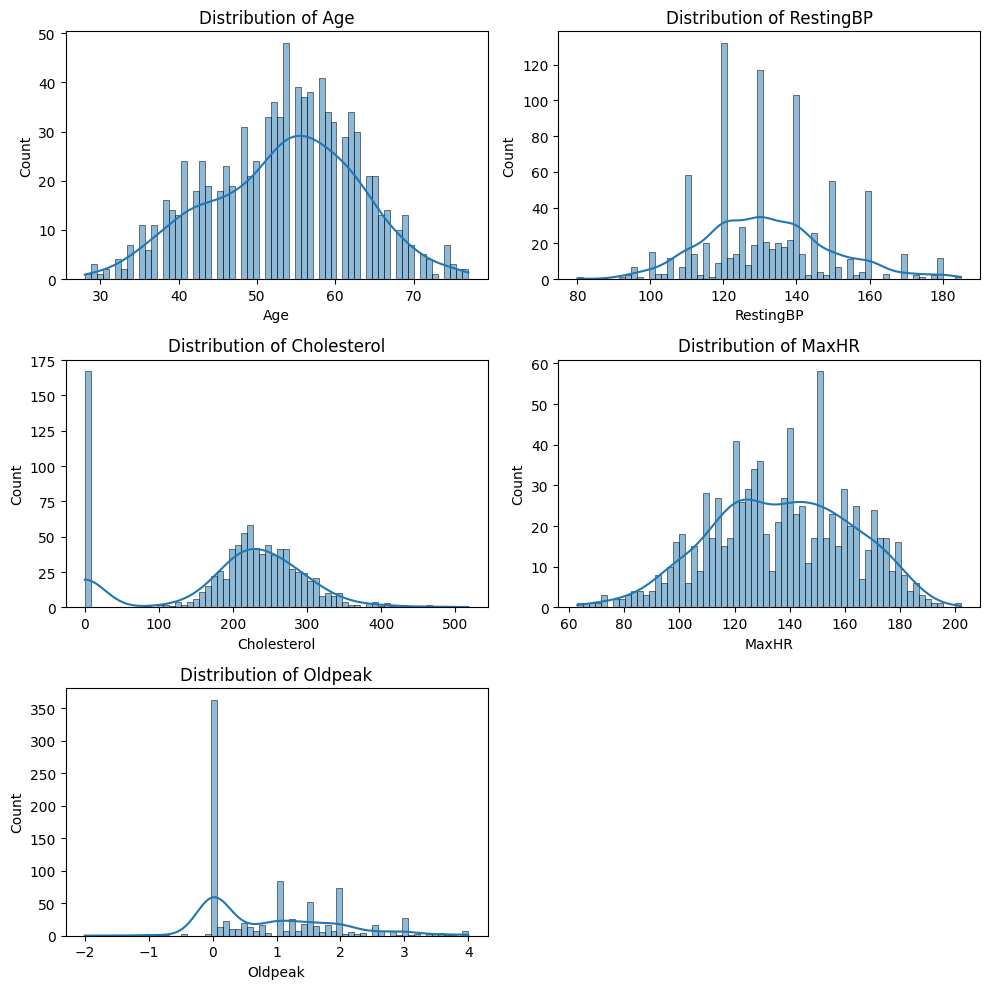

In [22]:
# Create subplots
n_plots = len(continuous_features)
plots_per_row = 2
n_rows = int(np.ceil(n_plots / plots_per_row))

fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(10, 10))
axes = axes.flatten()

# Plot each feature in a subplot
for idx, col in enumerate(continuous_features):
    sns.histplot(df[col], bins=64, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col}')

# Remove any empty subplots
for remaining_idx in range(idx+1, len(axes)):
    fig.delaxes(axes[remaining_idx])

plt.tight_layout()
plt.show()

- **Normalization** : `Oldpeak` and `Cholesterone` are normalized as they displayed a skewed data distribution.

- **Standardizarion** : `Age`, `RestingBP`, and `MaxHR` are standardized because these features are normally distributed.

In [23]:
normalizer = MinMaxScaler()  # Normalization

df_encoded['Oldpeak'] = normalizer.fit_transform(df_encoded[['Oldpeak']])
df_encoded['Cholesterol'] = normalizer.fit_transform(df_encoded[['Cholesterol']])

In [24]:
standardizer = StandardScaler()  # Standardization

df_encoded['Age'] = standardizer.fit_transform(df_encoded[['Age']])
df_encoded['RestingBP'] = standardizer.fit_transform(df_encoded[['RestingBP']])
df_encoded['MaxHR'] = standardizer.fit_transform(df_encoded[['MaxHR']])

In [25]:
df_encoded.describe()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
count,8.990000e+02,899.000000,8.990000e+02,899.000000,899.000000,8.990000e+02,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000
mean,-3.635703e-16,0.789766,-5.730183e-16,0.382250,0.232481,4.742221e-16,0.403782,0.476919,1.373749,0.547275,0.537264,0.190211,0.222469,0.050056,0.202447,0.604004,0.193548
std,1.000557e+00,0.407701,1.000557e+00,0.206868,0.422649,1.000557e+00,0.490928,0.167938,0.601057,0.498037,0.498887,0.392686,0.416136,0.218181,0.402047,0.489336,0.395299
min,-2.697887e+00,0.000000,-3.040540e+00,0.000000,0.000000,-2.916733e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.874774e-01,1.000000,-7.029132e-01,0.336873,0.000000,-6.675583e-01,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.319975e-02,1.000000,-1.185065e-01,0.428571,0.000000,4.270723e-02,0.000000,0.416667,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,6.880658e-01,1.000000,4.659002e-01,0.513514,0.000000,7.529728e-01,1.000000,0.583333,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2.486853e+00,1.000000,3.095730e+00,1.000000,1.000000,2.568096e+00,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Training

In [26]:
X = df_encoded.drop('HeartDisease',axis=1)
Y = df_encoded.HeartDisease

In [27]:
models_params = {
    'svc': {
        'model': SVC(),
        'param': {'C':[1, 5, 10, 20], 'kernel':['rbf', 'linear'], 'gamma':['auto', 'scale']}  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'param': {'n_estimators': [24, 48, 64]}
    },
    'logistic_regression': {
        'model': LogisticRegression(penalty='l2'),
        'param': {'C': [1, 5, 10, 20]}
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'param': {'criterion': ['gini', 'entropy']}
    }     
}

In [28]:
best_scores = []

for module_name, module_info in models_params.items():
    grid_search = GridSearchCV(module_info['model'], module_info['param'], cv=5, return_train_score=False)
    grid_search.fit(X, Y)
    best_scores.append({'model':module_info['model'], 'best_param':grid_search.best_params_, 'best_test_score': grid_search.best_score_})

In [29]:
pd.set_option('display.max_colwidth', None)
df_scores = pd.DataFrame(best_scores)
df_scores

,model,best_param,best_test_score
0,SVC(),"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.817492
1,RandomForestClassifier(),{'n_estimators': 24},0.835301
2,LogisticRegression(),{'C': 1},0.813054
3,DecisionTreeClassifier(),{'criterion': 'entropy'},0.766331


In [30]:
bagging = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=64,
    max_samples=0.8,
    bootstrap=True
)

In [31]:
cv_scores = cross_val_score(bagging, X, Y, cv=5)
cv_scores.mean()

0.8152451893234017